<a href="https://colab.research.google.com/github/gooran/kasreh-ezafeh/blob/main/eval_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/HLTT14/NLP-Assignments.git

Cloning into 'NLP-Assignments'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 117 (delta 59), reused 12 (delta 3), pack-reused 0
Receiving objects: 100% (117/117), 22.21 MiB | 8.35 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [3]:
!unzip -o -q /content/NLP-Assignments/Assignment2/test.zip

# Setup

In [4]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

from matplotlib import pyplot as plt

import seaborn as sns

from gensim.models import KeyedVectors

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.losses import BinaryCrossentropy

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Configuration


In [5]:
# Path to the data txt file on disk.
data_path = "/content/test.data"

# Prepare the data

In [6]:
df = pd.read_fwf(data_path, header = None, names=['word'],skip_blank_lines=False)

In [7]:
df = df.replace(np.nan, '', regex=True)

In [8]:
df.head()

,word
0,جسته‌وگریخته gen_positive
1,علائم gen_negative
2,و gen_negative
3,نشانه‌هایی gen_negative
4,می‌توان gen_negative


In [9]:
df['tag'] = df.apply(lambda row: '1' if 'gen_negative' in row.word.split() else '2', axis = 1)

In [10]:
df['word'] = df.apply(lambda row: row.word.replace('gen_negative', '').replace('gen_positive', '').strip(), axis = 1)

In [11]:
X = [] # store input sequence
Y = [] # store output sequence
X_sentence = []
Y_sentence = []
def word2sentence(row):
  global X_sentence,Y_sentence,X,Y
  if(row.word!=''):
    X_sentence.append(row.word)
    Y_sentence.append(row.tag)
  else:
    X.append(X_sentence)
    Y.append(Y_sentence)
    X_sentence = []
    Y_sentence = []

In [12]:
df.apply(lambda row: word2sentence(row), axis = 1);

In [13]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [14]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 6575
Vocabulary size: 16487
Total number of tags: 2


In [15]:
# let's look at first data point
# this is one data point that will be fed to the RNN
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['جسته\u200cوگریخته', 'علائم', 'و', 'نشانه\u200cهایی', 'می\u200cتوان', 'یافت', 'از', 'یک', 'ایدئولوژی', 'التقاطی', 'که', 'بر', 'اندیشه\u200cهای', 'فاشیستی', 'پیراهنی', 'دینی', 'می\u200cپوشاند', 'و', 'آرزوها', 'و', 'امیال', 'قدرت\u200cطلبانه', 'را', 'در', 'پس', 'ارزش\u200cها', 'و', 'آرمان\u200cهای', 'ملتی', 'دردمند', 'و', 'متعهد', 'پنهان', 'می\u200cسازد', '.'] 

sample Y:  ['2', '1', '1', '1', '1', '1', '1', '1', '2', '1', '1', '1', '2', '1', '1', '1', '1', '1', '1', '1', '2', '1', '1', '1', '2', '1', '1', '2', '1', '1', '1', '1', '1', '1', '1'] 



In [16]:
# In this many-to-many problem, the length of each input and output sequence must be the same.
# Since each word is tagged, it's important to make sure that the length of input sequence equals the output sequence
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence  : 35
Length of first output sequence : 35


# Vectorise X and Y
Encode X and Y to integer values

We'll use the Tokenizer() function from Keras library to encode text sequence to integer sequence

In [17]:
# encode X

word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [18]:
# encode Y

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [19]:
# look at first encoded data point

print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['جسته\u200cوگریخته', 'علائم', 'و', 'نشانه\u200cهایی', 'می\u200cتوان', 'یافت', 'از', 'یک', 'ایدئولوژی', 'التقاطی', 'که', 'بر', 'اندیشه\u200cهای', 'فاشیستی', 'پیراهنی', 'دینی', 'می\u200cپوشاند', 'و', 'آرزوها', 'و', 'امیال', 'قدرت\u200cطلبانه', 'را', 'در', 'پس', 'ارزش\u200cها', 'و', 'آرمان\u200cهای', 'ملتی', 'دردمند', 'و', 'متعهد', 'پنهان', 'می\u200cسازد', '.'] 

Y:  ['2', '1', '1', '1', '1', '1', '1', '1', '2', '1', '1', '1', '2', '1', '1', '1', '1', '1', '1', '1', '2', '1', '1', '1', '2', '1', '1', '2', '1', '1', '1', '1', '1', '1', '1'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [8733, 2171, 1, 3548, 289, 263, 6, 13, 3133, 4959, 7, 22, 4156, 4960, 8734, 484, 8735, 1, 6282, 1, 8736, 8737, 9, 3, 69, 2549, 1, 2550, 4157, 6283, 1, 2823, 2025, 1505, 4] 

Y:  [2, 1, 1, 1

In [20]:
# make sure that each sequence of input and output is same length

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


## Pad sequences
The next step after encoding the data is to define the sequence lengths. As of now, the sentences present in the data are of various lengths. We need to either pad short sentences or truncate long sentences to a fixed length. This fixed length, however, is a hyperparameter.

In [21]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 1230


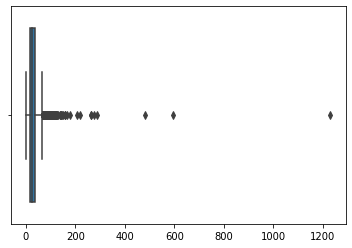

In [22]:
sns.boxplot(lengths)
plt.show()

In [23]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [24]:
# print the first sequence
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0 8733 2171    1 3548  289
  263    6   13 3133 4959    7   22 4156 4960 8734  484 8735    1 6282
    1 8736 8737    9    3   69 2549    1 2550 4157 6283    1 2823 2025
 1505    4] 



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1 1 1 2
 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1]


RNN will learn the zero to zero mapping while training. So we don't need to worry about the padded zeroes. Please note that zero is not reserved for any word or tag, it's only reserved for padding.

In [25]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

## Use one-hot encoding for output sequences (Y)

In [26]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)

In [27]:
# print Y of the first output sequqnce
print(Y.shape)

(6575, 100, 3)


## Loading the model

In [28]:
final_model = keras.models.load_model('/content/drive/MyDrive/final_model.h5')

In [29]:
# check summary of model
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 200)          11663200  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          135680    
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 40)           5160      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 3)            123       
Total params: 11,804,163
Trainable params: 135,803
Non-trainable params: 11,668,360
_________________________________________________________________


In [40]:
final_model.compile(loss=BinaryCrossentropy(),
              optimizer='adam',
              metrics=['acc', keras.metrics.Precision(), keras.metrics.Recall()])

## Load Test Data

In [41]:
X_test, Y_test = X, Y

# Final Model evaluation

In [42]:
loss, accuracy, precision, recall = final_model.evaluate(X_test, Y_test, verbose = 1)
# Calculate f1_score
f1_score = 2 * (precision * recall) / (precision + recall)
print("Loss: {0},\nAccuracy: {1},\nPrecision: {2},\nRecall: {3},\nf1_score: {4}".format(loss, accuracy, precision, recall,f1_score))

206/206 [==============================] - 3s 8ms/step - loss: 0.1575 - acc: 0.9321 - precision_1: 0.9353 - recall_1: 0.9283
Loss: 0.15750670433044434,
Accuracy: 0.9320517182350159,
Precision: 0.9352555274963379,
Recall: 0.9283239841461182,
f1_score: 0.9317768649590684
